In [1]:
## import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from train import get_npy_DbyDeep

from tensorflow import keras

import tensorflow as tf

ModuleNotFoundError: No module named 'train'

In [2]:
label_enc = {v:k for k, v in enumerate('ZARNDCQEGHILKMFPSTWYV')}  # Z : 0

In [3]:
for s in 'EICTIQSSGGIMLLKDQVLR':
    print(label_enc[s])

7
10
5
17
10
6
16
16
8
8
10
13
11
11
12
4
6
20
11
2


In [4]:
label_enc

{'Z': 0,
 'A': 1,
 'R': 2,
 'N': 3,
 'D': 4,
 'C': 5,
 'Q': 6,
 'E': 7,
 'G': 8,
 'H': 9,
 'I': 10,
 'L': 11,
 'K': 12,
 'M': 13,
 'F': 14,
 'P': 15,
 'S': 16,
 'T': 17,
 'W': 18,
 'Y': 19,
 'V': 20}

In [4]:
# gpu setting
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    except RuntimeError as e:
        print(e)

In [5]:
print('Loading model...')
model = keras.models.load_model("log/DbyDeep")

Loading model...


In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 81)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 81, 32)       672         input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 15)]         0                                            
______________________________________________________________________________________________

# HPP

In [7]:
df_hpp = pd.read_csv('data/HPP.csv')
df_hpp.rename({'Class':'label'}, axis=1, inplace=True)

In [8]:
print('Loading input peptides')
pep_hpp, n_hpp, c_hpp, m1_hpp, m2_hpp, label_hpp = get_npy_DbyDeep(df_hpp)

print('Making predictions')
model_pred = model.predict([pep_hpp, n_hpp, c_hpp, m1_hpp, m2_hpp])

Loading input peptides
Making predictions


In [14]:
df_hpp = pd.concat([df_hpp, pd.DataFrame(model_pred, columns=['probs'])['probs']], axis=1)

pe = df_hpp.loc[df_hpp['label']=='PE1'][['peptide', 'probs']].drop_duplicates()
dmp = df_hpp.loc[df_hpp['label']=='Detected_MPs'][['peptide', 'probs']].drop_duplicates()
mp = df_hpp.loc[df_hpp['label']=='MPs'][['peptide', 'probs']].drop_duplicates()

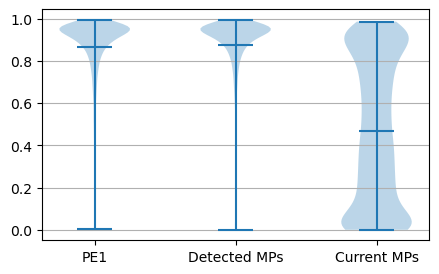

In [15]:
plt.figure(figsize=(5,3))
a = plt.violinplot([pe.probs.astype(float), 
                    dmp.probs.astype(float), 
                    mp.probs.astype(float)],
               showmeans=True,
              )
plt.xticks([y + 1 for y in range(len([pe,dmp,mp]))], ['PE1', 'Detected MPs', 'Current MPs'])
b = plt.grid(axis='y')
plt.show()

# massIVE-KB

In [9]:
df_test = pd.read_csv('data/test_diff_hpp.csv')

In [10]:
print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

Loading input peptides


In [11]:
probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

5352/5352 [==============================] - 42s 6ms/step - loss: 0.3574 - accuracy: 0.8412


Test Loss: 0.3573833703994751
Test Accuracy: 0.8412014245986938
Test AUC : 0.9211538762748492
              precision    recall  f1-score   support

       False     0.8507    0.8326    0.8416     86751
        True     0.8319    0.8500    0.8408     84510

    accuracy                         0.8412    171261
   macro avg     0.8413    0.8413    0.8412    171261
weighted avg     0.8414    0.8412    0.8412    171261



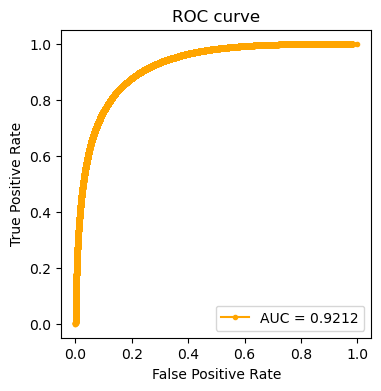

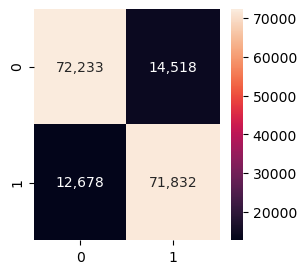

In [12]:
print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

# Figure

In [13]:
fpr_dmp = np.load('log/result_DeepMSpeptide_fpr.npy')
tpr_dmp = np.load('log/result_DeepMSpeptide_tpr.npy')

fpr_pf = np.load('log/result_PepFormer_fpr.npy')
tpr_pf = np.load('log/result_PepFormer_tpr.npy')

fpr_c = np.load('log/result_CapsNet_fpr.npy')
tpr_c = np.load('log/result_CapsNet_tpr.npy')

fpr_ap3 = np.load('log/result_AP3_fpr.npy')
tpr_ap3 = np.load('log/result_AP3_tpr.npy')

In [17]:
np.save('log/result_DbyDeep_fpr.npy', fpr)
np.save('log/result_DbyDeep_tpr.npy', tpr)

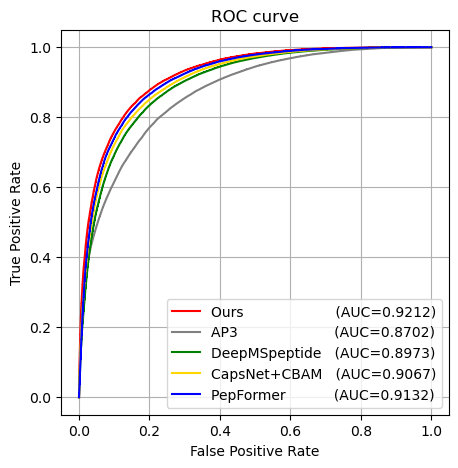

In [18]:
plt.figure(figsize=(5, 5))

# ours
plt.plot(fpr, tpr, marker=',', 
         label='Ours                     (AUC={:.4f})'.format(auc), 
         color='red')
plt.plot(fpr_ap3, tpr_ap3, marker=',', 
         label='AP3                      (AUC=0.8702)', 
         color='gray')
plt.plot(fpr_dmp, tpr_dmp, marker=',', 
         label='DeepMSpeptide   (AUC=0.8973)', 
         color='green')
plt.plot(fpr_c, tpr_c, marker=',', 
         label='CapsNet+CBAM   (AUC=0.9067)', 
         color='gold')
plt.plot(fpr_pf, tpr_pf, marker=',', 
         label='PepFormer           (AUC=0.9132)', 
         color='blue')



plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

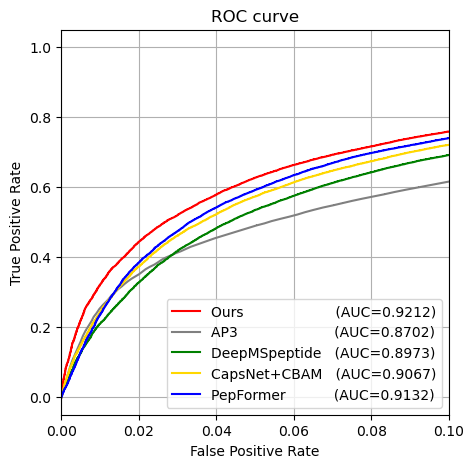

In [19]:
plt.figure(figsize=(5, 5))

# ours
plt.plot(fpr, tpr, marker=',', 
         label='Ours                     (AUC={:.4f})'.format(auc), 
         color='red')
plt.plot(fpr_ap3, tpr_ap3, marker=',', 
         label='AP3                      (AUC=0.8702)', 
         color='gray')
plt.plot(fpr_dmp, tpr_dmp, marker=',', 
         label='DeepMSpeptide   (AUC=0.8973)', 
         color='green')
plt.plot(fpr_c, tpr_c, marker=',', 
         label='CapsNet+CBAM   (AUC=0.9067)', 
         color='gold')
plt.plot(fpr_pf, tpr_pf, marker=',', 
         label='PepFormer           (AUC=0.9132)', 
         color='blue')



plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.xlim(0, 0.1)
# plt.ylim(0.4, 1)
plt.grid()
plt.show()

# Case of missed cleavage sites count

Test AUC : 0.8991571366991906
              precision    recall  f1-score   support

       False     0.7980    0.6221    0.6991     11076
        True     0.9031    0.9572    0.9294     40755

    accuracy                         0.8856     51831
   macro avg     0.8506    0.7896    0.8143     51831
weighted avg     0.8806    0.8856    0.8802     51831



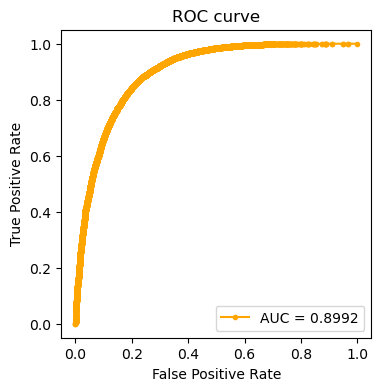

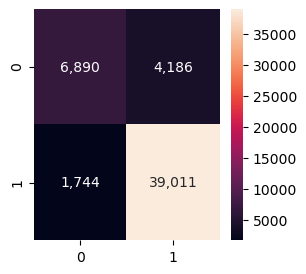

Test AUC : 0.8722390423076853
              precision    recall  f1-score   support

       False     0.7953    0.7641    0.7794     31999
        True     0.7803    0.8099    0.7948     33100

    accuracy                         0.7874     65099
   macro avg     0.7878    0.7870    0.7871     65099
weighted avg     0.7877    0.7874    0.7873     65099



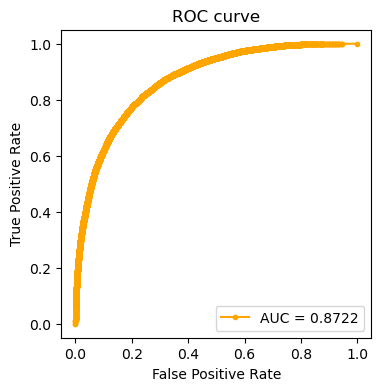

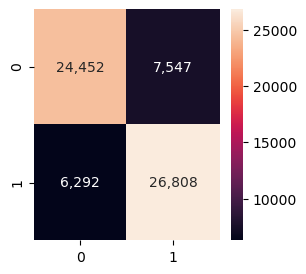

Test AUC : 0.8908095238136169
              precision    recall  f1-score   support

       False     0.8980    0.9362    0.9167     43676
        True     0.6832    0.5641    0.6180     10655

    accuracy                         0.8632     54331
   macro avg     0.7906    0.7502    0.7674     54331
weighted avg     0.8559    0.8632    0.8581     54331



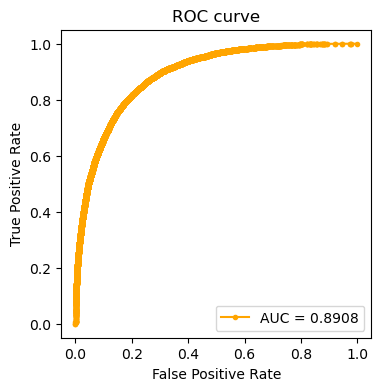

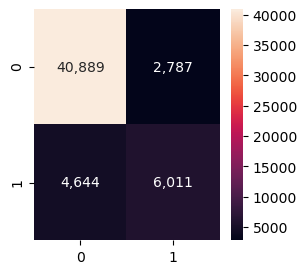

In [23]:
miss0_idx = df_test.loc[df_test.miss1=='ZZZZZZZZZZZZZZZ'].index
miss1_idx = df_test.loc[(df_test.miss1!='ZZZZZZZZZZZZZZZ') & (df_test.miss2=='ZZZZZZZZZZZZZZZ')].index
miss2_idx = df_test.loc[(df_test.miss1!='ZZZZZZZZZZZZZZZ') & (df_test.miss2!='ZZZZZZZZZZZZZZZ')].index

y_pred = np.array(y_pred)
probs_miss0 = probs[miss0_idx]
probs_miss1 = probs[miss1_idx]
probs_miss2 = probs[miss2_idx]
y_pred_miss0 = y_pred[miss0_idx]
y_pred_miss1 = y_pred[miss1_idx]
y_pred_miss2 = y_pred[miss2_idx]
label_test_miss0 = label_test[miss0_idx]
label_test_miss1 = label_test[miss1_idx]
label_test_miss2 = label_test[miss2_idx]

auc = roc_auc_score(label_test_miss0, probs_miss0)
print('Test AUC : {}'.format(auc))
print(classification_report(label_test_miss0, y_pred_miss0, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test_miss0, probs_miss0)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test_miss0, y_pred_miss0)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

auc = roc_auc_score(label_test_miss1, probs_miss1)
print('Test AUC : {}'.format(auc))
print(classification_report(label_test_miss1, y_pred_miss1, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test_miss1, probs_miss1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test_miss1, y_pred_miss1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

auc = roc_auc_score(label_test_miss2, probs_miss2)
print('Test AUC : {}'.format(auc))
print(classification_report(label_test_miss2, y_pred_miss2, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test_miss2, probs_miss2)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test_miss2, y_pred_miss2)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()



In [26]:
np.save('data/AP3_miss0_idx.npy', np.array(miss0_idx))
np.save('data/AP3_miss1_idx.npy', np.array(miss1_idx))
np.save('data/AP3_miss2_idx.npy', np.array(miss2_idx))